# Process True False Dataset

Dataset from the paper [The Internal State of an LLM Knows When It's Lying](https://aclanthology.org/2023.findings-emnlp.68.pdf)

You can download the dataset [here](http://azariaa.com/Content/Datasets/true-false-dataset.zip).

In [1]:
import pandas as pd
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer

from sklearn.metrics.pairwise import cosine_similarity

device = "cuda" if torch.cuda.is_available() else "CPU"
print(f'Device: {device}')

Device: cuda


In [2]:
dataset_name = 'true-false-dataset'
categories = ['animals', 'cities', 'companies', 'elements', 
              'facts', 'generated', 'inventions']

data_path = f'../Data/{dataset_name}'
embeddings_path = f'Embeddings/{dataset_name}'
concepts_path = f'Concepts/{dataset_name}'
cos_sims_path = f'Cosine_Similarities/{dataset_name}'

In [3]:
embeddings_file = os.path.join(embeddings_path, 'embeddings.pt')
if os.path.exists(embeddings_file):
    print('Embeddings file found. No need to load model and tokenizer.')
    model = None
    tokenizer = None
else:
    print('Embeddings file NOT found. Loading model and tokenizer...')
    
    from huggingface_hub import notebook_login
    notebook_login()
    
    model_name_or_path = "meta-llama/Meta-Llama-3-8B-Instruct"
    
    tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "left"
    
    model = AutoModelForCausalLM.from_pretrained(model_name_or_path)
    model.to(device)
    model.eval()
    print('Done.')

Embeddings file found. No need to load model and tokenizer.


## Processing statements

In [4]:
def get_category(category, data_path):
    cat_path = os.path.join(data_path, f'{category}_true_false.csv')
    df_cat = pd.read_csv(cat_path)
    df_cat['category'] = category
    return df_cat

In [5]:
def get_categories(categories, data_path):
    df_list = []
    for category in categories:
        df_cat = get_category(category, data_path=data_path)
        df_list.append(df_cat)
    df = pd.concat(df_list, ignore_index=True)
    return df

In [6]:
def get_hidden_states(statements, model, tokenizer, embeddings_path, 
                      device=device, save=True):
    embeddings_file = os.path.join(embeddings_path, 'embeddings.pt')
    if os.path.exists(embeddings_file):
        print('   Hidden states file found.')
        hidden_states = torch.load(embeddings_file)

    else:
        print('   Hidden states file NOT found.')
        hidden_states = []
        for statement in tqdm(statements, desc='Getting hidden states'):
            tokenized_prompt = tokenizer(statement, return_tensors="pt").to(device)
            output = model(**tokenized_prompt, output_hidden_states=True)
            
            features = output.hidden_states[-1][0][-1]
            hidden_state = features.cpu().detach()
            hidden_states.append(hidden_state)
            
            del output
            del features
            torch.cuda.empty_cache()
        hidden_states = torch.stack(hidden_states, dim=0)
        if save:
            os.makedirs(embeddings_path, exist_ok=True)
            torch.save(hidden_states, embeddings_file)
            
    return hidden_states

In [7]:
def process_data(categories, model, tokenizer, data_path, embeddings_path):
    print('Getting statements...', end=' ')
    df = get_categories(categories, data_path=data_path)
    df.to_csv(os.path.join(data_path, 'all_true_false.csv'))
    statements = df['statement'].to_list()
    print('Done.')

    print('Getting hidden states...')
    hidden_states = get_hidden_states(statements, model, tokenizer, embeddings_path)
    print('Done.')

    return df, hidden_states

In [8]:
df, hidden_states = process_data(categories, model, tokenizer, data_path, embeddings_path)

Getting statements... Done.
Getting hidden states...
   Hidden states file found.
Done.


In [9]:
print(f'Number of statements: {df.shape[0]}')
print(f'Number of true statements: {df[df["label"] == 1].shape[0]}')
print(f'Number of false statements: {df[df["label"] == 0].shape[0]}')
print(f'Number of statement categories: {len(df["category"].unique())}')

Number of statements: 6330
Number of true statements: 3187
Number of false statements: 3143
Number of statement categories: 7


## Computing concepts

In [10]:
def compute_single_concept(concept, concept_type, df, hidden_states):
    hidden_states_cat = hidden_states[df[concept_type] == concept] # Get embeddings from the concept
    concept_vect = torch.mean(hidden_states_cat, 0) # Get average embedding
    concept_vect = concept_vect / concept_vect.norm() # Normalize vector
    return concept_vect

def compute_concepts(df, hidden_states, concepts_path, save=True):
    label_map = {0: 'False', 1: 'True'}
    categories = list(df['category'].unique())
    labels = list(df['label'].unique())
    concept_names = categories
    concept_vectors = []

    print('Computing categories concept vectors...', end=' ')
    for category in categories:
        concept_vect = compute_single_concept(category, 'category', df, hidden_states)
        concept_vectors.append(concept_vect)
    print('Done.')

    print('Computing labels concept vectors...', end=' ')
    for label in labels:
        concept_vect = compute_single_concept(label, 'label', df, hidden_states)
        concept_vectors.append(concept_vect)
        concept_names.append(label_map[label])
    print('Done.')
        
    concept_vectors = torch.stack(concept_vectors, dim=0)
    if save:
        print('Saving concepts...', end=' ')
        os.makedirs(concepts_path, exist_ok=True)
        concept_vectors_path = os.path.join(concepts_path, 'concept_vectors.pt')
        concept_names_path = os.path.join(concepts_path, 'concept_names.pt')
        torch.save(concept_vectors, concept_vectors_path)
        torch.save(concept_names, concept_names_path)
        print('Done.')

    print(f'Concepts computed: {concept_names}')
    return concept_names, concept_vectors

In [11]:
concepts, concept_vectors = compute_concepts(df, hidden_states, concepts_path)

Computing categories concept vectors... Done.
Computing labels concept vectors... Done.
Saving concepts... Done.
Concepts computed: ['animals', 'cities', 'companies', 'elements', 'facts', 'generated', 'inventions', 'True', 'False']


## Compute cosine similarities

In [12]:
def compute_cosine_sims(hidden_states, concept_vectors, concepts, cos_sims_path,
                        save=True):
    print('Computing cosine similarities...', end=' ')
    similarities = cosine_similarity(hidden_states, concept_vectors)
    sim_df = pd.DataFrame(similarities, columns=concepts)
    print('Done.')
    if save:
        print('Saving cosine similarities...', end=' ')
        os.makedirs(cos_sims_path, exist_ok=True)
        cos_sims_df_path = os.path.join(cos_sims_path, 'cosine_similarities.csv')
        sim_df.to_csv(cos_sims_df_path)
        print('Done.')
        
    return sim_df

In [13]:
sim_df = compute_cosine_sims(hidden_states, concept_vectors, concepts, cos_sims_path)

Computing cosine similarities... Done.
Saving cosine similarities... Done.


In [14]:
def plot_cos_sim_histograms(df, sim_df):
    categories = list(df['category'].unique())
    fig, axs = plt.subplots(3, 3, figsize=(6,6), sharex=True, sharey=True)
    bins = np.linspace(0, 1, 20)
    for i, category in enumerate(categories):
        ix, iy = int(i/3), i%3
        axs[ix,iy].hist([sim_df[df['category']==category][category],
                         sim_df[df['category']!=category][category]],
                        bins,
                        label=['In concept', 'Out of concept'],
                        density=True)
        axs[ix,iy].set_title(category)
    
    label_map = {0: 'False', 1: 'True'}
    for label in [0,1]:
        i += 1
        ix, iy = int(i/3), i%3
        axs[ix,iy].hist([sim_df[df['label']==label][label_map[label]],
                         sim_df[df['label']!=label][label_map[label]]],
                        bins,
                        label=['In concept', 'Out of concept'],
                        density=True)
        axs[ix,iy].set_title(label_map[label])
    
    handles, labels = axs[0,0].get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor=(1.26, 0.9))
    fig.supxlabel('Cosine Similarity')
    fig.supylabel('Proportion of samples')
    fig.suptitle('Cosine similarity in/out of concept')
    fig.tight_layout()
    
    plt.show()

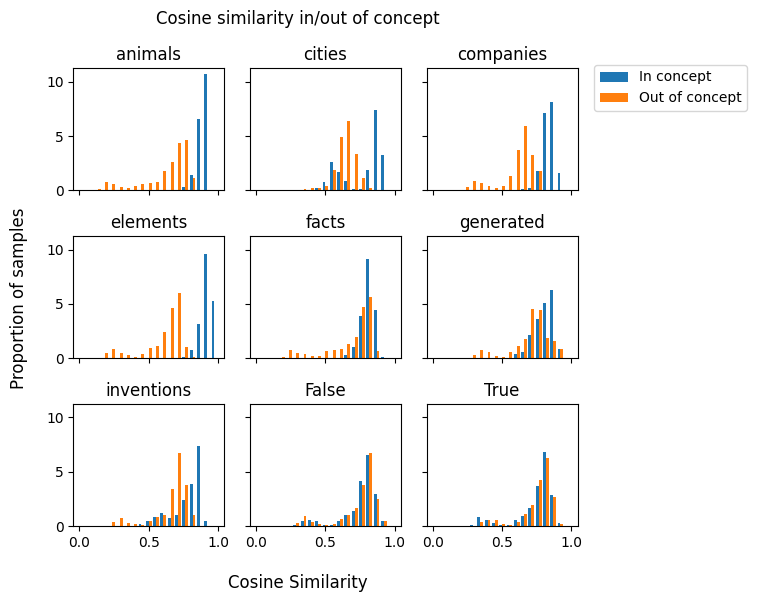

In [15]:
plot_cos_sim_histograms(df, sim_df)

In [16]:
def show_similarity_concepts(concept_vectors, concepts):
    cos_sim_concepts_df = compute_cosine_sims(concept_vectors, concept_vectors, concepts, '',
                                         save=False)
    cos_sim_concepts_df['Concept'] = concepts
    cos_sim_concepts_df = cos_sim_concepts_df.set_index('Concept')
    ax = sns.heatmap(cos_sim_concepts_df, annot=True, fmt=".2f", linewidth=.5, cmap="Blues",
               cbar_kws={'label': 'Cosine similarity'})
    ax.set_title('Cosine similarity between concepts')
    plt.show()

Computing cosine similarities... Done.


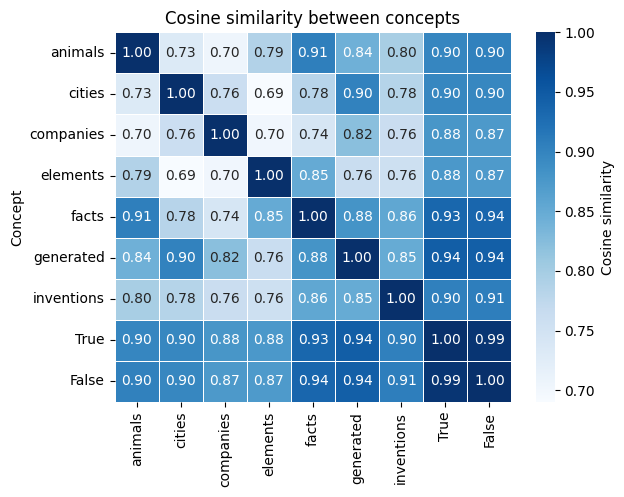

In [17]:
show_similarity_concepts(concept_vectors, concepts)